In [1]:
pip install geopandas

In [2]:
pip install pykrige scipy numpy pandas rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.9/854.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 46.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import Rbf
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


In [4]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Interpolation_KD_Singh/climate_data_nepal_district_wise_monthly.csv')


In [ ]:
df.head()

,DATE,YEAR,MONTH,DISTRICT,LAT,LON,Precepitation,Surface Pressure,Specific Humidity(kPa),Relative Humidity%,...,T2M_RANGE,Earth Skin tempr,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,12/31/2019,2019,12,Arghakhanchi,27.9,83.2,1.14,93.88,6.03,59.90,...,9.35,10.81,1.92,3.59,0.69,2.91,2.59,4.13,0.86,3.27
1,12/31/2019,2019,12,Baglung,28.3,83.6,1.21,79.58,4.37,62.81,...,9.05,1.84,1.68,3.48,0.43,3.05,1.70,3.09,0.49,2.60
2,12/31/2019,2019,12,Baitadi,29.5,80.5,2.13,73.98,2.78,56.49,...,13.90,-4.20,2.22,3.90,0.51,3.39,2.31,4.00,0.61,3.40
3,12/31/2019,2019,12,Bajang,29.6,81.2,1.98,67.93,2.24,61.59,...,14.85,-10.18,2.48,4.28,0.65,3.63,2.56,4.25,0.75,3.50
4,12/31/2019,2019,12,Banke,28.1,81.7,1.61,93.39,5.85,60.18,...,9.62,10.07,1.93,3.40,0.77,2.64,2.51,3.86,1.04,2.82


In [11]:
# Assuming you have a 'Date' column in your CSV file, you can parse it into a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract data for the year 2019
data_2019 = df[df['DATE'].dt.year == 2019]
#data7 = df[(df["YEAR"] == 2019) & (df["MONTH"] == 7)]


In [7]:
# Create an array of months
months = range(1, 13)

In [8]:
# Define the grid for interpolation (LAT and LON values)
lat = np.linspace(data_2019['LAT'].min(), data_2019['LAT'].max(), num=100)
lon = np.linspace(data_2019['LON'].min(), data_2019['LON'].max(), num=100)


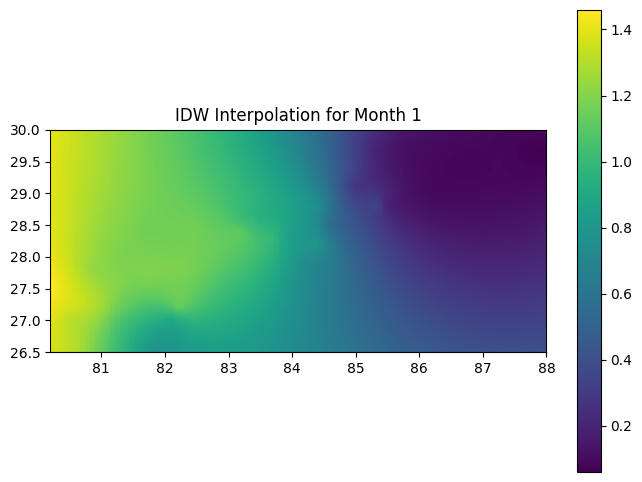

IDW RMSE: 0.04
IDW MAE: 0.02


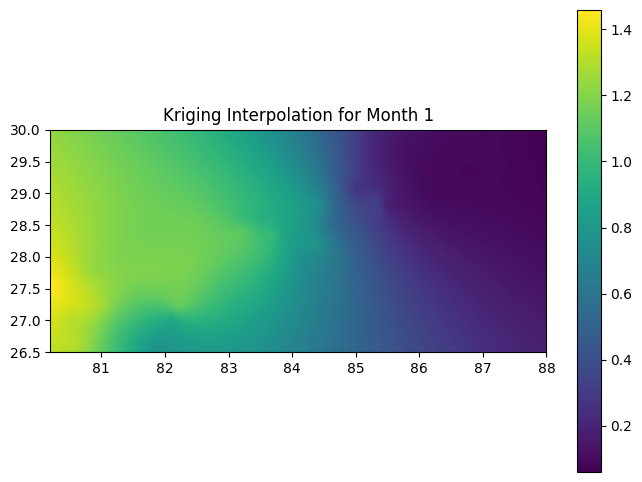

Kriging RMSE: 0.03
Kriging MAE: 0.02


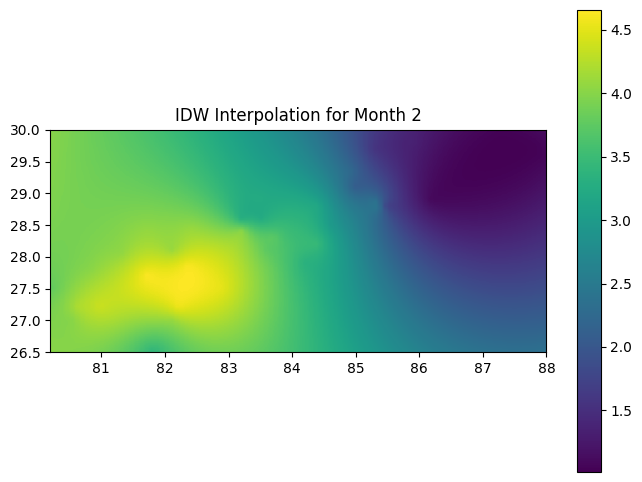

IDW RMSE: 0.21
IDW MAE: 0.12


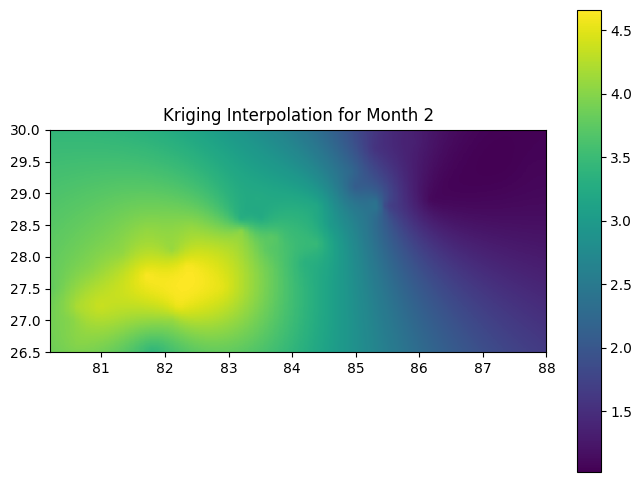

Kriging RMSE: 0.19
Kriging MAE: 0.10


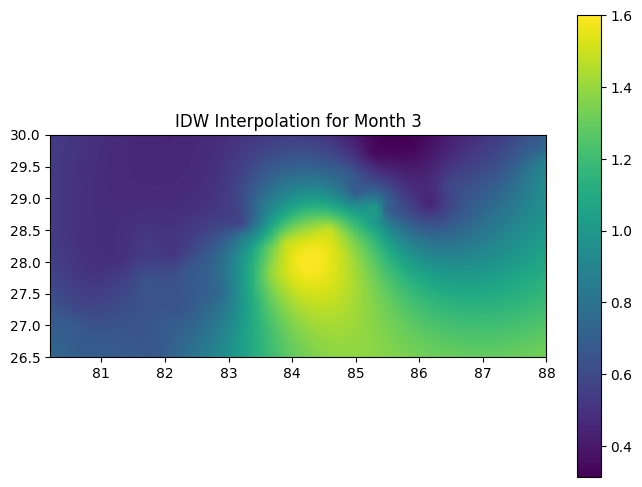

IDW RMSE: 0.15
IDW MAE: 0.10


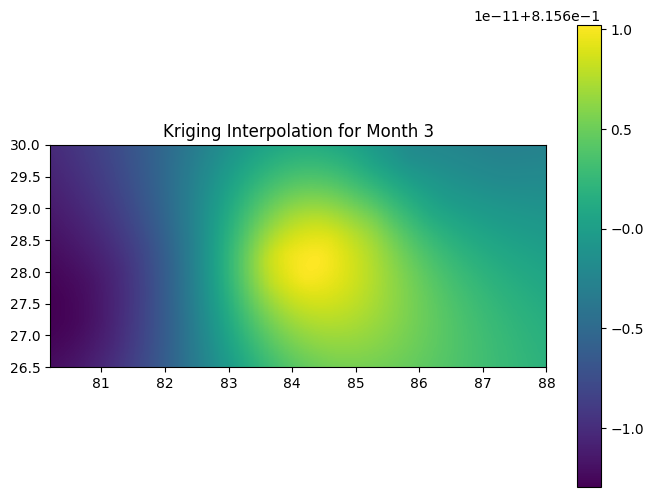

Kriging RMSE: 0.34
Kriging MAE: 0.29


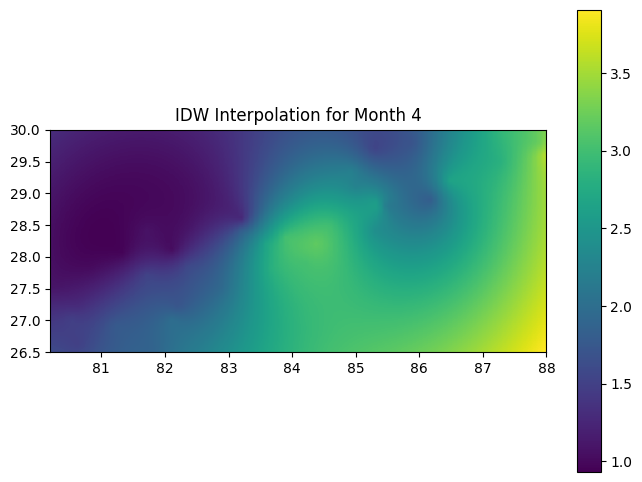

IDW RMSE: 0.48
IDW MAE: 0.30


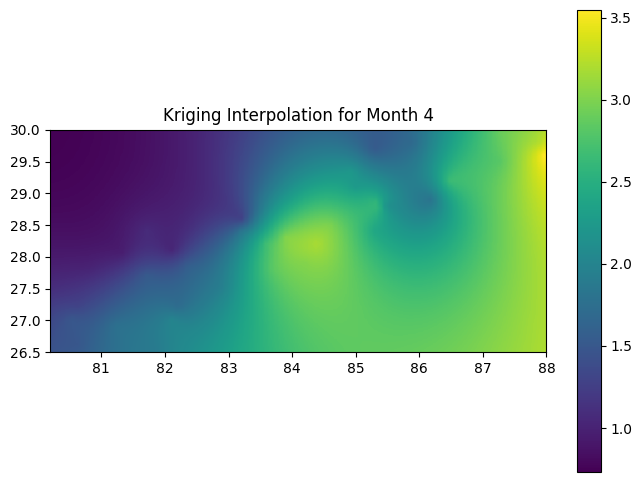

Kriging RMSE: 0.46
Kriging MAE: 0.29


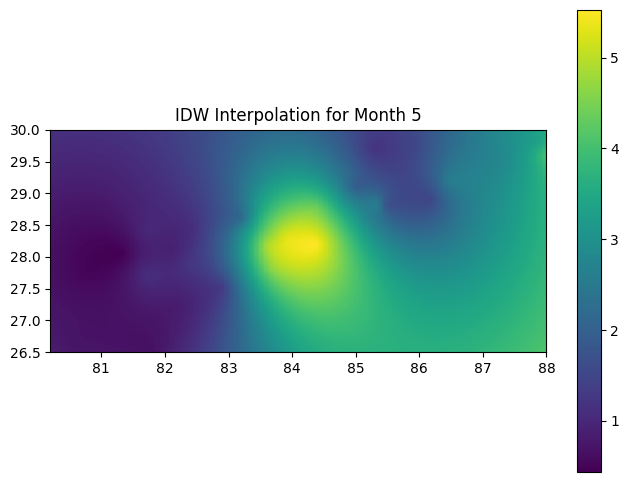

IDW RMSE: 0.58
IDW MAE: 0.37


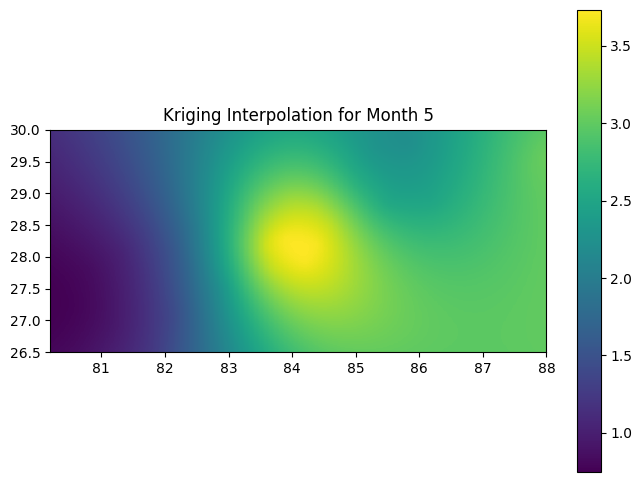

Kriging RMSE: 0.88
Kriging MAE: 0.64


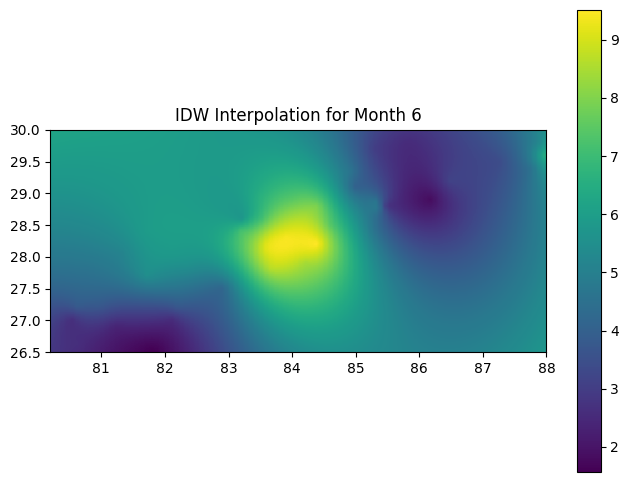

IDW RMSE: 0.76
IDW MAE: 0.54


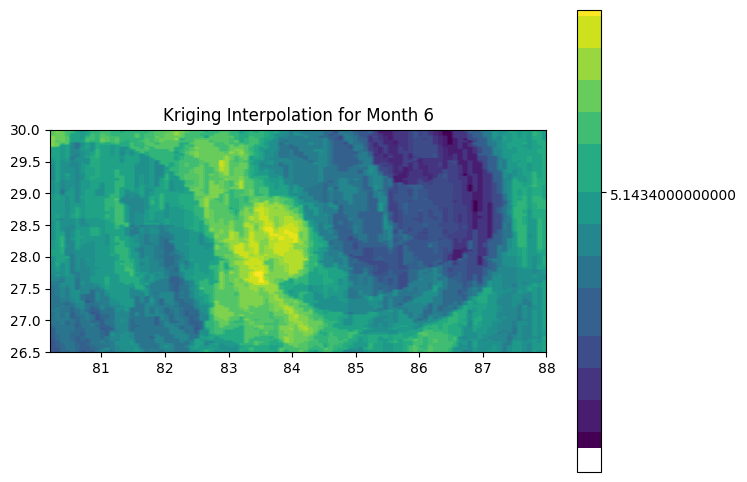

Kriging RMSE: 2.30
Kriging MAE: 1.90


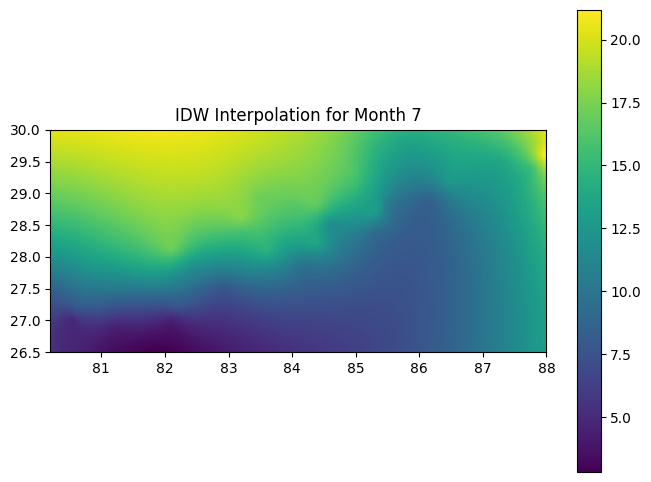

IDW RMSE: 1.78
IDW MAE: 1.30


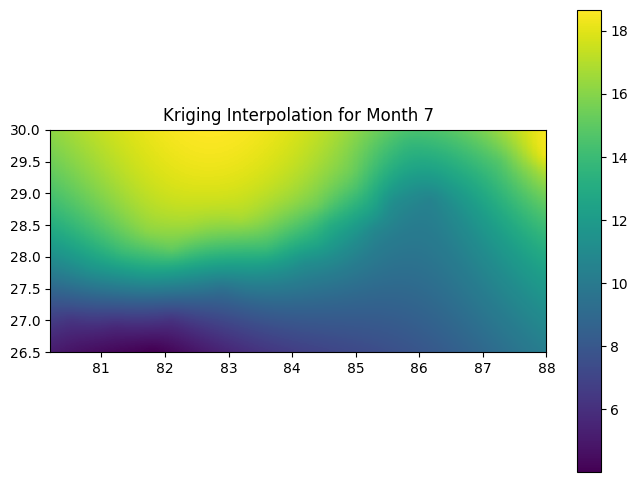

Kriging RMSE: 1.94
Kriging MAE: 1.12


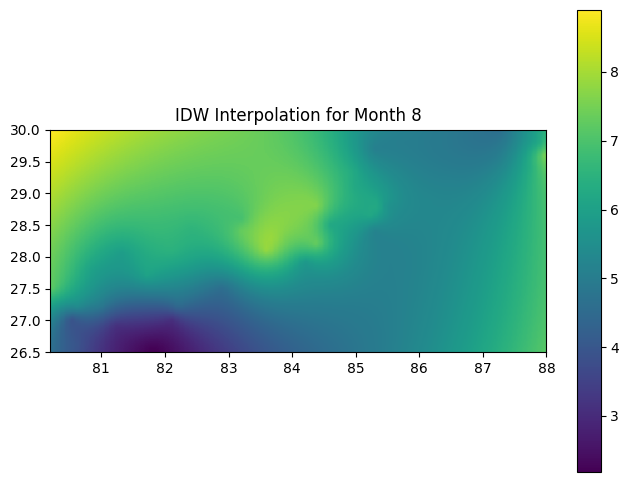

IDW RMSE: 0.53
IDW MAE: 0.40


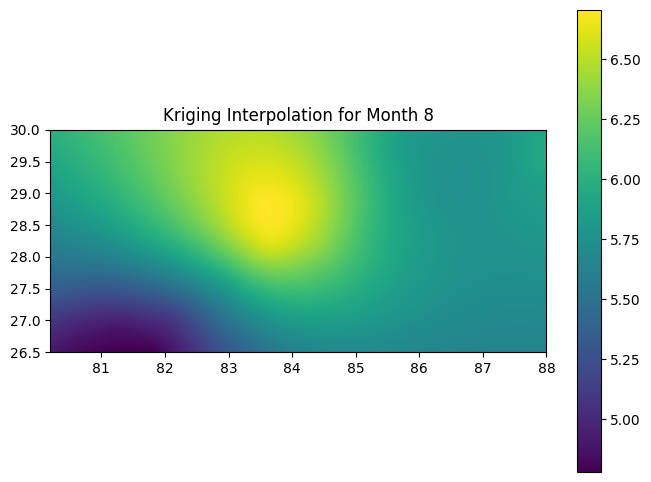

Kriging RMSE: 0.91
Kriging MAE: 0.81


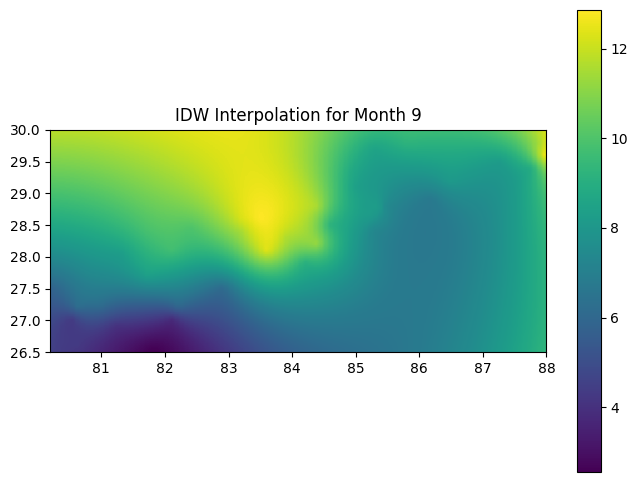

IDW RMSE: 1.02
IDW MAE: 0.73


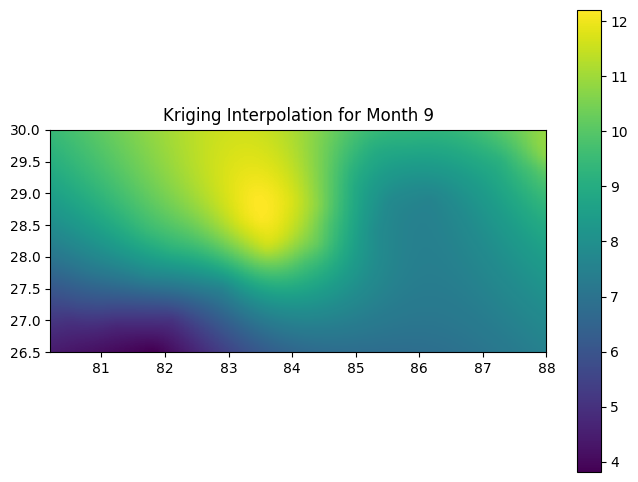

Kriging RMSE: 1.19
Kriging MAE: 0.77


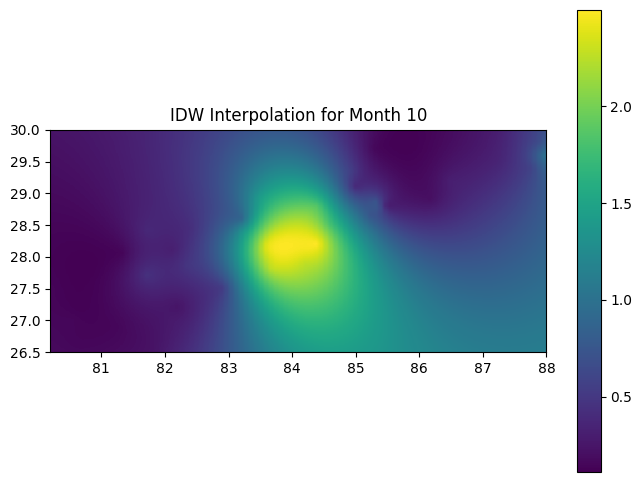

IDW RMSE: 0.13
IDW MAE: 0.10


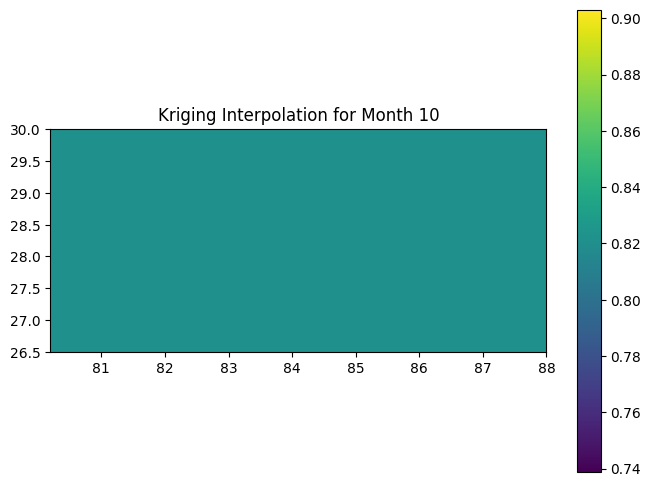

Kriging RMSE: 0.76
Kriging MAE: 0.65


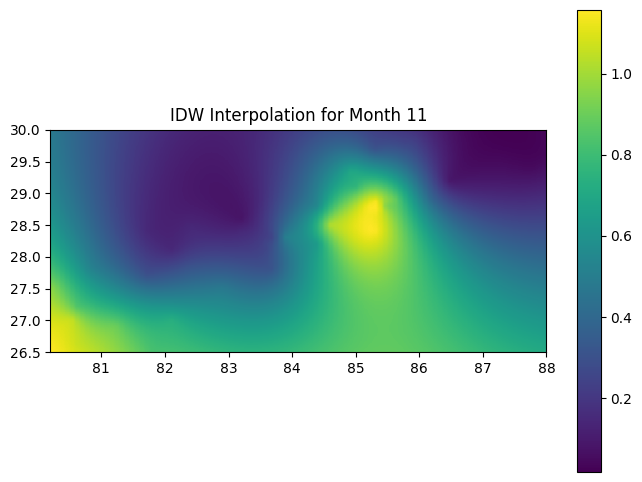

IDW RMSE: 0.10
IDW MAE: 0.07


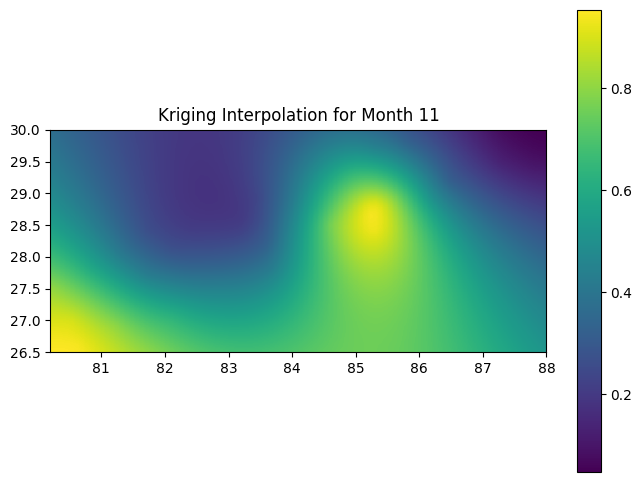

Kriging RMSE: 0.15
Kriging MAE: 0.14


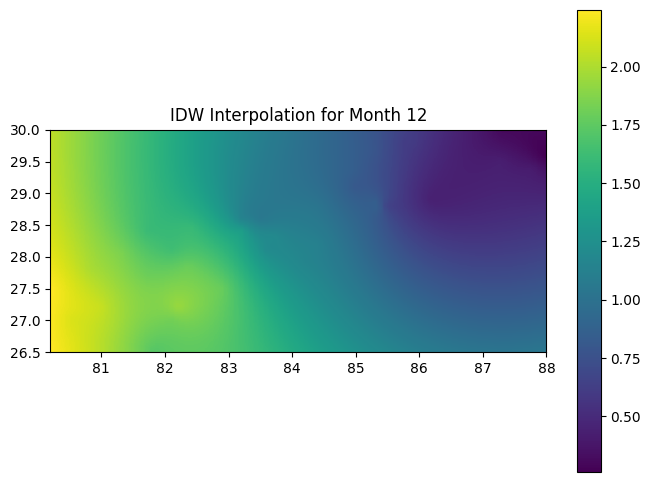

IDW RMSE: 0.07
IDW MAE: 0.05


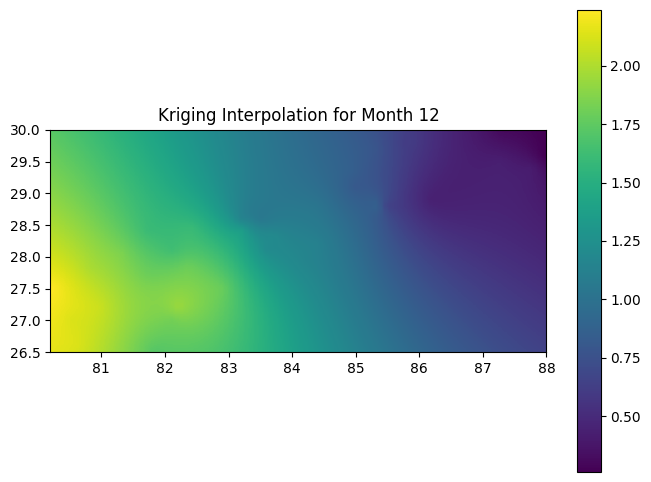

Kriging RMSE: 0.07
Kriging MAE: 0.05


In [10]:
# Iterate through each month, interpolate, and plot
for month in months:
    # Filter data for the specific month
    data_month = data_2019[data_2019['MONTH'] == month]

    # Separating the data into training and test datasets
    # Define a percentage for the test data (e.g., 20%)
    test_percentage = 0.2
    test_size = int(test_percentage * len(data_month))
    training_data = data_month[:-test_size]
    test_data = data_month[-test_size:]

    # Create a mesh grid
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Interpolate using IDW
    rbf = Rbf(training_data["LON"], training_data["LAT"], training_data["Precepitation"], function="linear")
    rainfall_idw = rbf(lon_grid, lat_grid)

    # Interpolate using Kriging
    ok = OrdinaryKriging(training_data["LON"], training_data["LAT"], training_data["Precepitation"], variogram_model="linear")
    z, ss = ok.execute("grid", lon, lat)

    # Export Kriging and IDW results as GeoTIFF rasters
    with rasterio.open("kriging_rainfall.tif", 'w', driver='GTiff', height=len(lat), width=len(lon),
                      count=1, dtype=str(z.dtype), crs='EPSG:4326', transform=from_origin(lon.min(), lat.max(), abs(lon[1] - lon[0]), abs(lat[1] - lat[0]))) as dst_kriging:
        dst_kriging.write(z, 1)
    with rasterio.open("idw_rainfall.tif", 'w', driver='GTiff', height=len(lat), width=len(lon),
                       count=1, dtype=str(rainfall_idw.dtype), crs='EPSG:4326', transform=from_origin(lon.min(), lat.max(), abs(lon[1] - lon[0]), abs(lat[1] - lat[0]))) as dst_idw:
        dst_idw.write(rainfall_idw, 1)

    # Interpolate the precipitation values for the test data
    rbf_test = Rbf(training_data['LON'], training_data['LAT'], training_data['Precepitation'], function='linear')
    rainfall_idw_test = rbf_test(test_data['LON'], test_data['LAT'])

    ok_test = OrdinaryKriging(training_data['LON'], training_data['LAT'], training_data['Precepitation'], variogram_model='linear')
    z_test, _ = ok_test.execute('points', test_data['LON'], test_data['LAT'])

    # Calculate RMSE and MAE
    rmse_idw = np.sqrt(mean_squared_error(test_data['Precepitation'], rainfall_idw_test))
    mae_idw = mean_absolute_error(test_data['Precepitation'], rainfall_idw_test)

    rmse_kriging = np.sqrt(mean_squared_error(test_data['Precepitation'], z_test))
    mae_kriging = mean_absolute_error(test_data['Precepitation'], z_test)



    # Plot the rasters (optional)
    plt.figure(figsize=(8, 6))
    plt.imshow(rainfall_idw, extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()))
    plt.title(f'IDW Interpolation for Month {month}')
    plt.colorbar()
    plt.show()
    print(f'IDW RMSE: {rmse_idw:.2f}')
    print(f'IDW MAE: {mae_idw:.2f}')

    plt.figure(figsize=(8, 6))
    plt.imshow(z, extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()))
    plt.title(f'Kriging Interpolation for Month {month}')
    plt.colorbar()
    plt.show()
    print(f'Kriging RMSE: {rmse_kriging:.2f}')
    print(f'Kriging MAE: {mae_kriging:.2f}')